# Risk forecasting DNN model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

import yfinance as yf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, GRU, Bidirectional

from sklearn.model_selection import train_test_split
from scipy.stats import norm

In [2]:
SERIES_PERIOD = '5y'
SERIES_INTERVAL = '1d'

LOOKBACK_WINDOW = 10
TRAIN_TEST_SPLIT = 0.9

EPOCHS = 50
BATCH_SIZE = 32

### Dataset

In [3]:
# fetch closing values
sp500 = '^GSPC'

sp500_data = yf.Ticker(sp500)
sp500_history = sp500_data.history(period=SERIES_PERIOD, interval=SERIES_INTERVAL)
close = sp500_history.Close.loc[sp500_history.Close != 0][:-1]

# compute logarithmic returns
log_returns = np.log(close) - np.log(close.shift(1))
log_returns.dropna(inplace=True)

# compute numerical volitility as standard deviation over 5-point rolling window
stds = close.pct_change().rolling(5).std()

# generate dataframe of closing prices and log returns
X = pd.DataFrame({
    'close': (close - close.min()) / close.max(),
    'returns': (np.abs(log_returns) - np.abs(log_returns).min()) / np.abs(log_returns).max(),
    'stds': (stds - stds.min()) / stds.max()
})

# remove NaN values and normalise
X.dropna(inplace=True)

X

/Users/tom/opt/miniconda3/envs/ThesisEnv/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,close,returns,stds
Date,,,
2017-06-12,0.040027,0.007617,0.011441
2017-06-13,0.042312,0.035209,0.018294
2017-06-14,0.041805,0.007751,0.019367
2017-06-15,0.040667,0.017510,0.022363
2017-06-16,0.040810,0.002168,0.022051
...,...,...,...
2022-05-26,0.379530,0.154179,0.121411
2022-05-27,0.400462,0.191413,0.131836
2022-05-31,0.395023,0.049253,0.151998


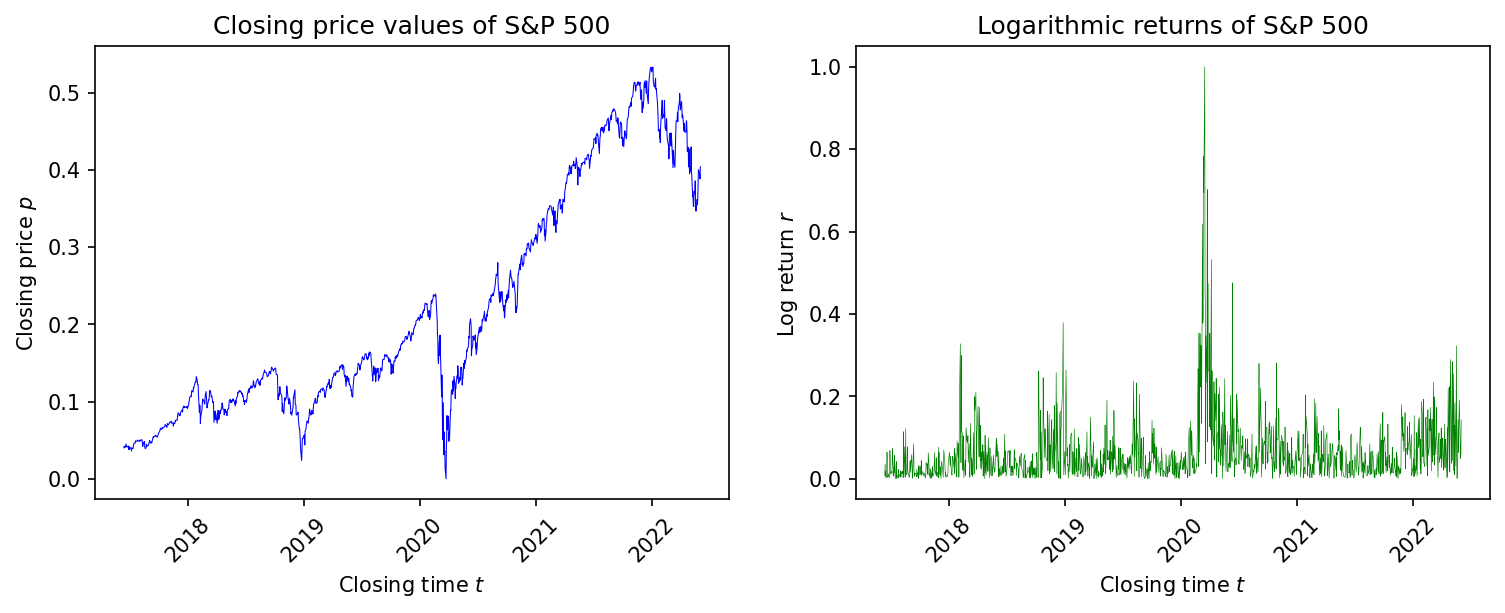

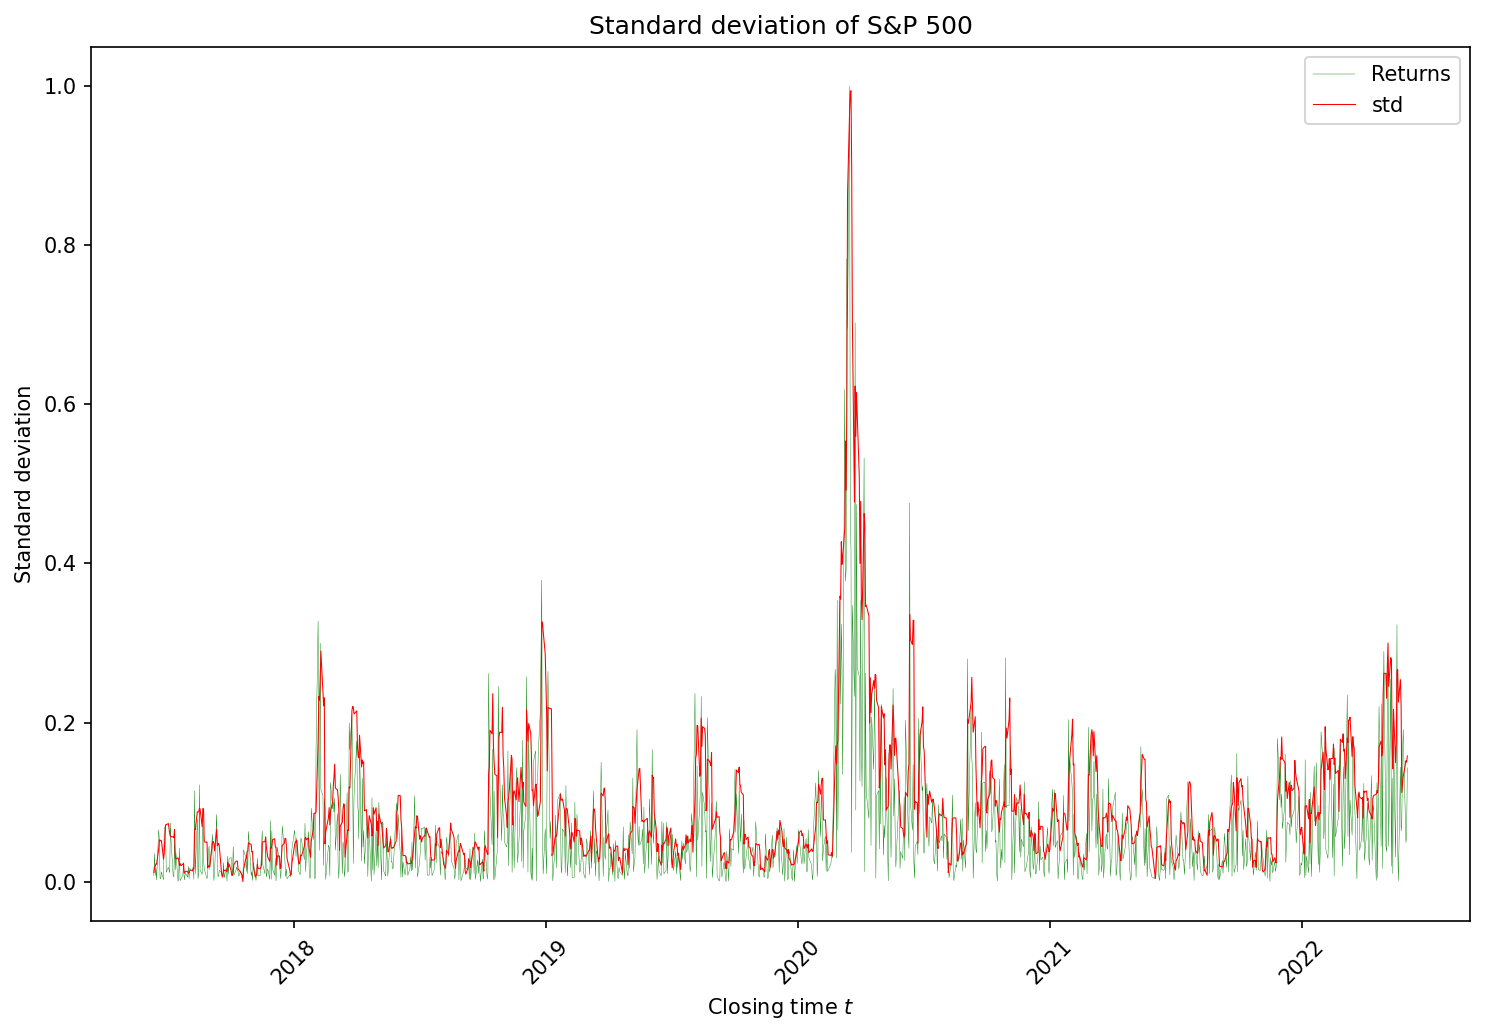

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), dpi=150)

ax[0].plot(X.close, linewidth=0.5, color='b')
ax[0].set(title=f'Closing price values of S&P 500', xlabel=r'Closing time $t$', ylabel=r'Closing price $p$')
ax[0].tick_params(axis='x', rotation=45)

ax[1].plot(X.returns, linewidth=0.3, color='g')
ax[1].set(title=f'Logarithmic returns of S&P 500', xlabel=r'Closing time $t$', ylabel=r'Log return $r$')
ax[1].tick_params(axis='x', rotation=45)

fig, ax = plt.subplots(figsize=(10, 7), dpi=150)
ax.plot(X.returns, linewidth=0.2, color='g', label='Returns')
ax.plot(X.stds, linewidth=0.5, color='r', label='std')
ax.set(title=f'Standard deviation of S&P 500', xlabel=r'Closing time $t$', ylabel=r'Standard deviation')
ax.tick_params(axis='x', rotation=45)
ax.legend()

plt.tight_layout()
plt.show()

In [5]:
# build dataset:
#   each instance consists of a `LOOKBACK_WINDOW` length time series (prev `LOOKBACK_WINDOW`) over variables
#   each label is the VIX value that comes at the next timestep after this series
X_data = []
y_data = []

for i in range(X.shape[0] - LOOKBACK_WINDOW):
    X_data.append((
        X.close[i: i + LOOKBACK_WINDOW],
        X.returns[i: i + LOOKBACK_WINDOW],
        X.stds[i: i + LOOKBACK_WINDOW],
    ))
    y_data.append((
        X.close[i + LOOKBACK_WINDOW],
        X.returns[i + LOOKBACK_WINDOW],
        X.stds[i + LOOKBACK_WINDOW],
    ))

# convert X to numpy
X_data = np.array(X_data)

# convert y to numpy
y_data = np.array(y_data)

print(X_data.shape, y_data.shape)

# split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=(1 - TRAIN_TEST_SPLIT), shuffle=False)

# train_test_split = math.floor(X_data.shape[0] * TRAIN_TEST_SPLIT)

# X_test = X_data[train_test_split:]
# y_test = y_data[train_test_split:]

# X_train_raw = X_data[:train_test_split]
# y_train_raw = y_data[:train_test_split]

# # shuffle X and y in unision
# X_train = np.empty(X_train_raw.shape, dtype=X_train_raw.dtype)
# y_train = np.empty(y_train_raw.shape, dtype=y_train_raw.dtype)
# perm = np.random.permutation(X_train_raw.shape[0])

# for i_old, i_new in enumerate(perm):
#     X_train[i_new] = X_train_raw[i_old]
#     y_train[i_new] = y_train_raw[i_old]

print(X_train.shape, y_train.shape, '\n', X_test.shape, y_test.shape)

(1244, 3, 10) (1244, 3)
(1119, 3, 10) (1119, 3) 
 (125, 3, 10) (125, 3)


In [6]:
# build RNN comprising of one LSTM layer and one FCN layer
rnn_model = Sequential([
    SimpleRNN(256, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1:])),
    SimpleRNN(256, activation='tanh'),
    Dense(3, activation='linear')
])

rnn_model.compile(loss='mae', optimizer='adam', metrics=['mse'])

2022-06-04 17:38:47.491503: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
rnn_history = rnn_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/50
35/35 [==============================] - 1s 4ms/step - loss: 0.1239 - mse: 0.0614
Epoch 2/50
35/35 [==============================] - 0s 6ms/step - loss: 0.0240 - mse: 0.0018
Epoch 3/50
35/35 [==============================] - 0s 4ms/step - loss: 0.0239 - mse: 0.0019
Epoch 4/50
35/35 [==============================] - 0s 4ms/step - loss: 0.0248 - mse: 0.0020
Epoch 5/50
35/35 [==============================] - 0s 3ms/step - loss: 0.0231 - mse: 0.0018
Epoch 6/50
35/35 [==============================] - 0s 4ms/step - loss: 0.0226 - mse: 0.0018
Epoch 7/50
35/35 [==============================] - 0s 4ms/step - loss: 0.0213 - mse: 0.0017
Epoch 8/50
35/35 [==============================] - 0s 5ms/step - loss: 0.0219 - mse: 0.0018
Epoch 9/50
35/35 [==============================] - 0s 4ms/step - loss: 0.0224 - mse: 0.0018
Epoch 10/50
35/35 [==============================] - 0s 5ms/step - loss: 0.0210 - mse: 0.0018
Epoch 11/50
35/35 [==============================] - 0s 5ms/step - lo

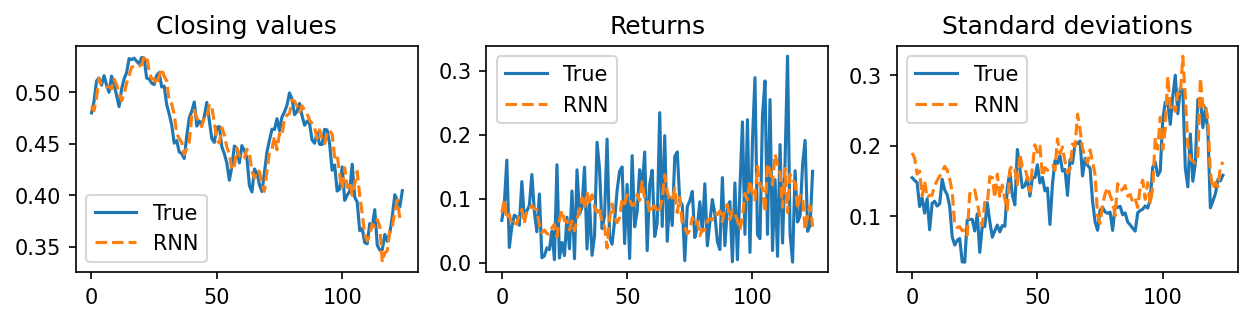

In [8]:
rnn_pred = rnn_model.predict(X_test)

fig, ax = plt.subplots(1, 3, figsize=(10, 2), dpi=150)

ax[0].plot(y_test[:, 0], label='True')
ax[0].plot(rnn_pred[:, 0], linestyle='--', label='RNN')
ax[0].legend()
ax[0].set(title='Closing values')

ax[1].plot(y_test[:, 1], label='True')
ax[1].plot(rnn_pred[:, 1], linestyle='--', label='RNN')
ax[1].legend()
ax[1].set(title='Returns')

ax[2].plot(y_test[:, 2], label='True')
ax[2].plot(rnn_pred[:, 2], linestyle='--', label='RNN')
ax[2].legend()
ax[2].set(title='Standard deviations')

plt.show()

[Text(0.5, 1.0, 'Value at risk')]

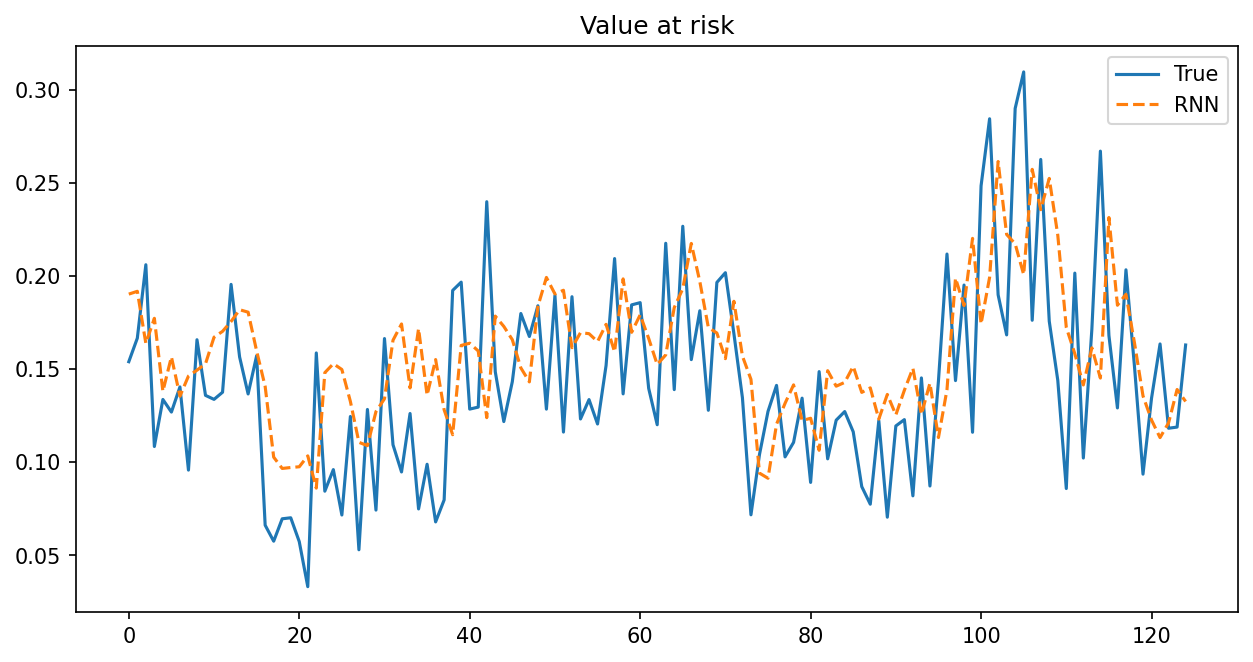

In [9]:
# VaR prediction
def value_at_risk(close, ret, s_dev, confidence_level=0.05):
    # VaR = V_p * (R_p – z * σ) = portfolio_value * (portfolio return - Z value * portfolio std)
    var = close * (ret - norm.ppf(confidence_level) * s_dev)
    
    return var


VaR_pred = value_at_risk(rnn_pred[:, 0], rnn_pred[:, 1], rnn_pred[:, 2])
VaR_test = value_at_risk(y_test[:, 0], y_test[:, 1], y_test[:, 2])

fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=150)

ax.plot(VaR_test, label='True')
ax.plot(VaR_pred, linestyle='--', label='RNN')
ax.legend()
ax.set(title='Value at risk')